In [1]:
print(1)


1


In [ ]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import gc
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from config import *
import re

### Data set-up

In [3]:
def get_sara():
    return ir_datasets.load('sara')

def sara_docs():
    for doc in sara_dataset.docs_iter():
        doc_id = doc.doc_id
        text = doc.text
        sens = doc.sensitivity
        text_method = doc.default_text()
        
        e = email.message_from_string(text_method)
        pl = e.get_payload()

        print(doc_id, sens)
        break

sara_dataset = get_sara()

In [4]:

def dataset_to_df():
    doc_ids = []
    doc_text = []
    doc_sens = []
    for doc in sara_dataset.docs_iter():
        doc_ids.append(doc.doc_id)
        doc_text.append(doc.text)
        doc_sens.append(doc.sensitivity)

    sara_dict = {'doc_id':doc_ids, 'text':doc_text, 'sensitivity':doc_sens}
    df = pd.DataFrame.from_dict(sara_dict)
    return df


sara_df = dataset_to_df()


In [5]:
testing_sample = sara_df.sample(frac=0.2, random_state=1)
value_counts = testing_sample.sensitivity.value_counts()

'''
doc_lengths = testing_sample.text.str.len()
cannot_load = testing_sample[doc_lengths > 12000]
value_counts = cannot_load.sensitivity.value_counts()
'''

doc_lengths = testing_sample.text.str.len()
temp_testing_sample = testing_sample[doc_lengths < 12000]
testing_sample = temp_testing_sample

sampled_indices = testing_sample.index
training_data = sara_df.drop(sampled_indices)

### Llama 2 with SARA

In [ ]:
access_token = l2_token
model_name = "meta-llama/Llama-2-7b-chat-hf" # "TheBloke/Llama-2-7B-Chat-GPTQ" #"TheBloke/Llama-2-13B-GPTQ"   #"meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, use_auth_token=access_token)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", use_auth_token=access_token, cache_dir=my_cache) #, revision='gptq-8bit-64g-actorder_True')

In [7]:
def old_get_prompt_template(prompt):
  return f"""[INST] <<SYS>>
  You are a helpful, respectful and honest assistant. Always answer as helpfully as possible. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
  <</SYS>>
  The degree of sensitivity in text is regarded as how much personal information is exposed within the text. Classify the text into non-sensitive or sensitive.
  Text: {prompt}
  Sensitivity classification:[/INST]
  """

def old_base_prompt_template(document):
  return f"""[INST]
  Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
  The Text is delimited by triple backticks. You must answer after 'Attribute:'[/INST]
  
  Text: ```{document}```.

  Attribute: 
  """

In [8]:
def base_prompt_template(document):
  return f"""[INST]
  The Text is sensitive if it contains sensitive personal information.
  Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
  The Text is delimited by triple backticks. You must answer after 'Attribute:'[/INST]
  
  Text: ```{document}```.

  Attribute: 
  """

def context_prompt_template(document):
  return f"""[INST]
  Which one of the attributes “sensitive”, “non-sensitive” classifies the Text.
  When classifying the Text only consider personal information that is sensitive. 
  The Text is delimited by triple backticks. You must answer after 'Attribute:'[/INST]
  
  Text: ```{document}```.

  Note: You must choose the attribute "sensitive" or "non-sensitive" to classify the Text and output only the attribute after 'Attirbute:'.
  Attribute: 
  """

def get_prompt_template(document, prompt):
   return prompt(document)

In [9]:
def llm_inference(document, prompt, model):
  inputs = tokenizer(get_prompt_template(document, prompt), return_tensors='pt')
  generation_config = GenerationConfig(
    # Unable to set temperature to 0 - https://github.com/facebookresearch/llama/issues/687 - use do_sample=False for greedy decoding
    do_sample=False,
    max_new_tokens=20,
  )
  output = model.generate(inputs=inputs.input_ids.cuda(), attention_mask=inputs.attention_mask.cuda(), generation_config=generation_config)
  return tokenizer.decode(output[0], skip_special_tokens=True)

def display_gen_text(output):
  #return output[-80:]
  end_template = output.find('\n  Attribute') #'output only the attribute after')
  return output[end_template:]
  '''
  # Generates entire prompt + new tokens - cut out prompt from dislay
  end_template = output.find('[/INST]')
  return output[end_template:]
  '''

def prompt_to_reply(d, p):
  response = llm_inference(d, p, model)
  return display_gen_text(response)


In [10]:
# String matching on model response
def post_process_classification(classification, ground_truth):
    if 'non-sensitive' in classification.lower():
        if ground_truth == 0:
            return 'TN', 0
        else:
            return 'FN', 0

    elif 'sensitive' in classification.lower() and 'non-sensitive' not in classification.lower():
        if ground_truth == 1:
            return 'TP', 1
        else:
            return 'FP', 1

    else:
        # Further processing required
        return classification, None
        further_processing_required[sample[1].doc_id] = classification


def clear_memory():
    # Prevents cuda out of memory
    torch.cuda.empty_cache()
    gc.collect()


# Dataset - dataframe, prompt_strategy - prompt function name
def llm_experiment(dataset, prompt_strategy=base_prompt_template):
    predictions = {
        'TP' : 0, # Sensitive
        'FP' : 0, # Non-sensitive document classified as sensitive
        'TN' : 0, # Non-sensitive
        'FN' : 0,
    }
    # Model output is not an expected sensitivity attribute
    further_processing_required = {}
    # All model output
    model_responses = {}
    
    #total_samples = 50

    scikit_true = []
    scikit_pred = []

    for sample in dataset.iterrows():
        sample_text = sample[1].text
        ground_truth = sample[1].sensitivity

        # To replace with appropriate pre-processing
        if len(sample_text) > 12000:
            continue
        
        classification = prompt_to_reply(sample_text, prompt_strategy)
        model_responses[sample[1].doc_id] = classification

        quadrant, pred = post_process_classification(classification, ground_truth)
        if pred == None:
            further_processing_required[sample[1].doc_id] = quadrant
            continue

        predictions[quadrant] = predictions.get(quadrant) + 1
        scikit_true.append(ground_truth)
        scikit_pred.append(pred)

        clear_memory()

        #total_samples -= 1
        #if total_samples == 0:
        #    break

    #print(predictions)
    return predictions, further_processing_required, model_responses, scikit_true, scikit_pred


#predictions, further_processing_required, model_responses, scikit_true, scikit_pred = llm_experiment(sara_df, prompt_strategy)

### Evaluation summary

In [11]:
def basic_metrics(true_labels, predictions):
    acc = accuracy_score(true_labels, predictions)
    bac = balanced_accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average=None)


def evaluation_summary(description, true_labels, predictions):
    target_classes = ['Non-sensitive (0)', 'Sensitive (1)']
    print("Evaluation for: " + description)
    print(classification_report(true_labels, predictions, digits=3, zero_division=0, target_names=target_classes))
    print('\n\nConfusion matrix:')
    confusionMatrix = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=target_classes) 
    disp.plot()
    plt.show()
 

#evaluation_summary("Llama-2", scikit_true, scikit_pred)

### ML methods

#### Dummy classifiers

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [14]:
testing_sample = sara_df.sample(frac=0.2, random_state=1)

In [15]:
def dummys(train, test):
    vectorizer = CountVectorizer()
    vectorizer.fit(train.text.tolist())

    train_features = vectorizer.transform(train.text.tolist())
    test_features = vectorizer.transform(test.text.tolist())
    train_labels = train.sensitivity
    test_labels = test.sensitivity

    dummy_mf = DummyClassifier(strategy="most_frequent")
    dummy_mf.fit(train_features, train_labels)
    mf_test_preds = dummy_mf.predict(test_features)
    evaluation_summary("Dummy MF", test_labels, mf_test_preds)


    dummy_rand = DummyClassifier(strategy="stratified")
    dummy_rand.fit(train_features, train_labels)
    rand_test_preds = dummy_rand.predict(test_features)
    evaluation_summary("Dummy Random stratified sampling", test_labels, rand_test_preds)

    return mf_test_preds, rand_test_preds


#dummys(training_data, testing_sample)

#### Logistic regression and SVM - with TF-IDF

In [16]:
def lr_svm_tdidf(train, test):
    tfidf_vectoizer = TfidfVectorizer()
    train_tfidf = tfidf_vectoizer.fit_transform(train.text.tolist())
    test_tfidf = tfidf_vectoizer.transform(test.text.tolist())

    lr = LogisticRegression(max_iter=500)
    lr.fit(train_tfidf, train.sensitivity)
    lr_preds = lr.predict(test_tfidf)
    evaluation_summary("LR", test.sensitivity, lr_preds)

    svm_model = SVC()
    svm_model.fit(train_tfidf, train.sensitivity)
    svm_preds = svm_model.predict(test_tfidf)
    evaluation_summary("SVM", test.sensitivity, svm_preds)

    return lr_preds, svm_preds

### Results

Evaluation for: Dummy MF
                   precision    recall  f1-score   support

Non-sensitive (0)      0.897     1.000     0.946       305
    Sensitive (1)      0.000     0.000     0.000        35

         accuracy                          0.897       340
        macro avg      0.449     0.500     0.473       340
     weighted avg      0.805     0.897     0.848       340



Confusion matrix:


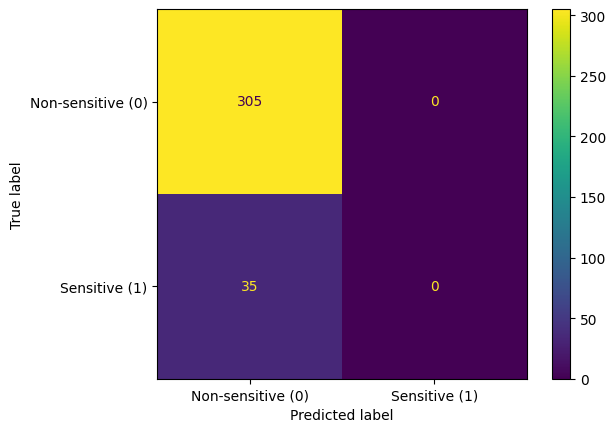

Evaluation for: Dummy Random stratified sampling
                   precision    recall  f1-score   support

Non-sensitive (0)      0.898     0.892     0.895       305
    Sensitive (1)      0.108     0.114     0.111        35

         accuracy                          0.812       340
        macro avg      0.503     0.503     0.503       340
     weighted avg      0.816     0.812     0.814       340



Confusion matrix:


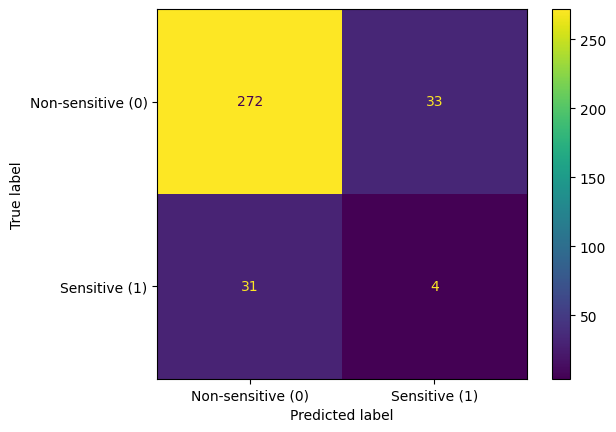

Evaluation for: LR
                   precision    recall  f1-score   support

Non-sensitive (0)      0.913     0.993     0.951       305
    Sensitive (1)      0.750     0.171     0.279        35

         accuracy                          0.909       340
        macro avg      0.831     0.582     0.615       340
     weighted avg      0.896     0.909     0.882       340



Confusion matrix:


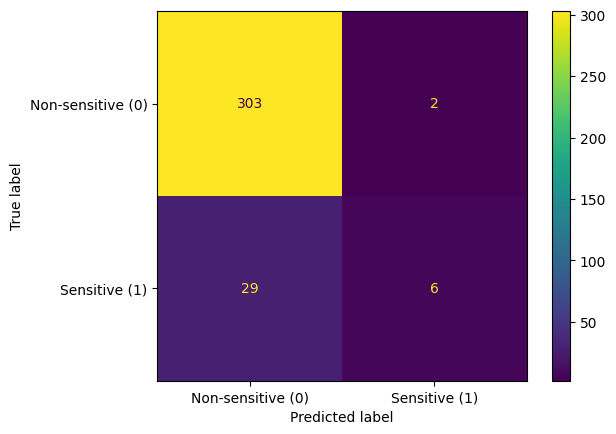

Evaluation for: SVM
                   precision    recall  f1-score   support

Non-sensitive (0)      0.918     0.990     0.953       305
    Sensitive (1)      0.727     0.229     0.348        35

         accuracy                          0.912       340
        macro avg      0.823     0.609     0.650       340
     weighted avg      0.898     0.912     0.890       340



Confusion matrix:


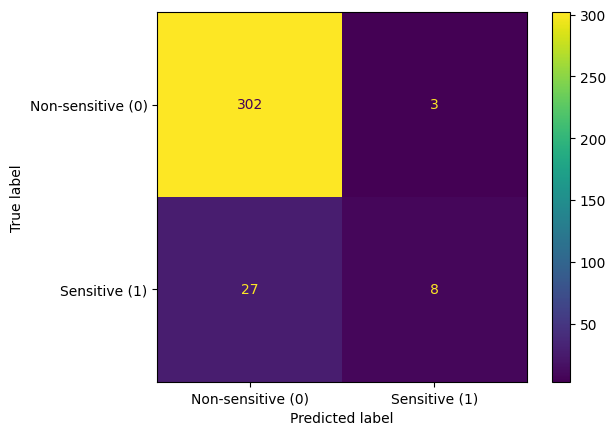

In [17]:
mf_test_preds, rand_test_preds = dummys(training_data, testing_sample)
lr_preds, svm_preds = lr_svm_tdidf(training_data, testing_sample)

In [ ]:
predictions, further_processing_required, model_responses, scikit_true, scikit_pred = llm_experiment(testing_sample, base_prompt_template)
evaluation_summary("Llama-2 Base", scikit_true, scikit_pred)

In [19]:
def get_metric_dict(method, labels, preds):
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    metric_dict = {'accuracy': acc, 'f1_score': f1, 'balanced accuracy': bac}
    metrics_data[method] = metric_dict


metrics_data = {}

get_metric_dict('Dummy MF', testing_sample.sensitivity, mf_test_preds)
get_metric_dict('Dummy Rand', testing_sample.sensitivity, rand_test_preds)
get_metric_dict('LR TF-IDF', testing_sample.sensitivity, lr_preds)
get_metric_dict('SVM TF-IDF', testing_sample.sensitivity, svm_preds)
get_metric_dict('Llama-2', scikit_true, scikit_pred)
metrics_data

{'Dummy MF': {'accuracy': 0.8970588235294118,
  'f1_score': 0.8483812129502964,
  'balanced accuracy': 0.5},
 'Dummy Rand': {'accuracy': 0.8117647058823529,
  'f1_score': 0.8140694874441005,
  'balanced accuracy': 0.5030444964871195},
 'LR TF-IDF': {'accuracy': 0.9088235294117647,
  'f1_score': 0.8821306697992257,
  'balanced accuracy': 0.5824355971896955},
 'SVM TF-IDF': {'accuracy': 0.9117647058823529,
  'f1_score': 0.8904168717274318,
  'balanced accuracy': 0.609367681498829},
 'Llama-2': {'accuracy': 0.3573667711598746,
  'f1_score': 0.433458661793497,
  'balanced accuracy': 0.5263581488933602}}

In [20]:
metrics_df = pd.DataFrame.from_dict(metrics_data, orient='index')
metrics_df

,accuracy,f1_score,balanced accuracy
Dummy MF,0.897059,0.848381,0.500000
Dummy Rand,0.811765,0.814069,0.503044
LR TF-IDF,0.908824,0.882131,0.582436
SVM TF-IDF,0.911765,0.890417,0.609368
Llama-2,0.357367,0.433459,0.526358


### More results

In [31]:
testing_sample = sara_df.sample(n=10, random_state=1)
#testing_sample = sara_df.sample(frac=0.2, random_state=1)

In [22]:
def get_orig(message, find_orig_message):
    #line_start = message.rfind('\n', 0, find_orig_message)
    line_start = find_orig_message
    base_message = message[:line_start]
    line_end = find_orig_message + 5 #message.find('\n', find_orig_message)
    orig_message = message[line_end:]
    return base_message, orig_message

def get_separate_messages(message):
    payload = message.split('\r\n\r\n')[1]
    separate_messages = []

    find_fwd_message = payload.find('\n----- Forw')
    find_orig_message = payload.find('-----Original Message-')
    
    n = payload
    while (find_fwd_message > 0 or find_orig_message > 0):
        if (find_fwd_message > 0 and find_orig_message > 0):
            if find_fwd_message < find_orig_message:
                b, n = get_orig(n, find_fwd_message)
            else:
                b, n = get_orig(n, find_orig_message)
        elif (find_fwd_message > 0 and find_orig_message < 0):
            b, n = get_orig(n, find_fwd_message)
        else:
            b, n = get_orig(n, find_orig_message)
        
        find_fwd_message = n.find('\n----- Forw')
        find_orig_message = n.find('-----Original Message-')

        b = re.sub(r'\s+', ' ', b)
        separate_messages.append(b)

    n = re.sub(r'\s+', ' ', n)
    separate_messages.append(n)

    return separate_messages

def preprocessing_dataframe():
    ids = []
    texts = []
    sens = []
    preproc = {}

    for s in testing_sample.iterrows():
        separate_messages = get_separate_messages(s[1].text)

        if len(separate_messages) == 1:
            ids.append(s[1].doc_id)
            texts.append(separate_messages[0])
            sens.append(s[1].sensitivity)
        else:
            for i, m in enumerate(separate_messages):
                id_part = s[1].doc_id + '_' + str(i)
                ids.append(id_part)
                texts.append(m)
                sens.append(s[1].sensitivity)

    preproc['doc_id'] = ids
    preproc['text'] = texts
    preproc['sensitivity'] = sens
    return preproc

preproc = preprocessing_dataframe()

#print(preproc)
preproc_df = pd.DataFrame.from_dict(preproc)
preproc_df


,doc_id,text,sensitivity
0,177860_0,"Call at 5:00 today (3:00 your time), if you can.",1
1,177860_1,Original Message----- From: Kevin Scott <kevin...,1
2,54263_0,"Philip, Please, try Frank Wolak from Stanford ...",1
3,54263_1,"Original Message----- From: ""philip annesley"" ...",1
4,54263_2,Original Message----- From: Vince.J.Kaminski@e...,1
5,54263_3,"Original Message----- From: ""philip annesley"" ...",1
6,54629_0,"Mike, Thanks for your message. The meeting on ...",0
7,54629_1,Original Message----- From: Mike Boughton <bou...,0
8,175555,---------------------- Forwarded by Steven J K...,0


In [34]:
def obase_prompt_template(document):
  return f"""[INST]
  The Text is sensitive if it contains sensitive personal information.
  Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
  The Text is delimited by triple backticks. You must answer after 'Attribute:'[/INST]
  
  Text: ```{document}```.

  Note: You must choose the attribute "sensitive" or "non-sensitive" to classify the Text and output only the attribute after 'Attribute:'.
  Attribute: 
  """

# We seem to keep getting over confidence on sensitive predictions. Ignore email addresses within meta data as this may be classified as sensitive personal information. Rather than cleaning all the data right now - context manager use.
def obase_prompt_template(document):
  return f"""[INST]
  The Text is sensitive if it contains sensitive personal information. Note names, email addresses and phone numbers are not regarded as sensitive personal information.
  Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
  The Text is delimited by triple backticks. You must answer after 'Attribute:'[/INST]
  
  Text: ```{document}```.

  Note: You must choose the attribute "sensitive" or "non-sensitive" to classify the Text and output only the attribute after 'Attribute:'.
  Attribute: 
  """

def base_prompt_template(document):
  return f"""[INST]
  The Text is sensitive if it contains sensitive personal information. Note email metadata such as the headers and signatures are not regarded as sensitive personal information.
  Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
  The Text is delimited by triple backticks. You must answer after 'Attribute:'[/INST]
  
  Text: ```{document}```.

  Note: You must choose the attribute "sensitive" or "non-sensitive" to classify the Text and output only the attribute after 'Attribute:'. Explain your decision.
  Attribute: 
  """


def base_w_sys(document):
  return f"""<s>[INST] <<SYS>>
  You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

  If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
  <</SYS>>
  
  The Text is sensitive if it contains sensitive personal information. Note email metadata such as the headers and signatures are not regarded as sensitive personal information. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. The Text is delimited by triple backticks. You must answer after 'Attribute:'.
  
  Text: ```{document}```.
  
  Note: You must choose the attribute "sensitive" or "non-sensitive" to classify the Text and output only the attribute after 'Attribute:'.
  Attribute: [/INST]
  """

def base_w_sys2(document):
  return f"""<s>[INST] <<SYS>>
  You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

  If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
  <</SYS>>
  
  The Text is sensitive if it contains sensitive personal information. Note email metadata such as the headers and signatures are not regarded as sensitive personal information. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. The Text is delimited by triple backticks. You must answer after 'Attribute:'.
  
  Text: ```{document}```.
  
  Note: You must choose the attribute "sensitive" or "non-sensitive" to classify the Text and output only the attribute after 'Attribute:' [/INST].
  Attribute: 
  """

def base_w_sys3(document):
  return f"""[INST] <<SYS>>
  You are a helpful AI assistant. Always answer as helpfully as possible.
  
  Your response must start with <ANSWER> and end with </ANSWER>.
  <</SYS>>
  
  The Text is sensitive if it contains sensitive personal information. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. You must answer with "sensitive" or "non-sensitive". The Text is delimited by triple backticks. Note email metadata such as the headers and signatures are not regarded as sensitive personal information.[/INST]
  
  Text: ```{document}```.
  
  <ANSWER>
  """

def base_w_sys4(document):
  return f"""The Text is sensitive if it contains sensitive personal information. Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. You must answer with "sensitive" or "non-sensitive" and your response must start with <ANSWER> and end with </ANSWER>. The Text is delimited by triple backticks. Note email metadata is not sensitive personal information.
  
  Text: ```{document}```.
  
  <ANSWER>
  """

def display_gen_text(output):
  end_template = output.find('\n  <ANSWER>')
  return output[end_template:]

def display_gen_textattr(output):
  #return output[-80:]
  end_template = output.find('\n  Attribute:') #'output only the attribute after')
  #print(end_template)
  return output[end_template:]

Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      0.286     0.667     0.400         3
    Sensitive (1)      0.500     0.167     0.250         6

         accuracy                          0.333         9
        macro avg      0.393     0.417     0.325         9
     weighted avg      0.429     0.333     0.300         9



Confusion matrix:


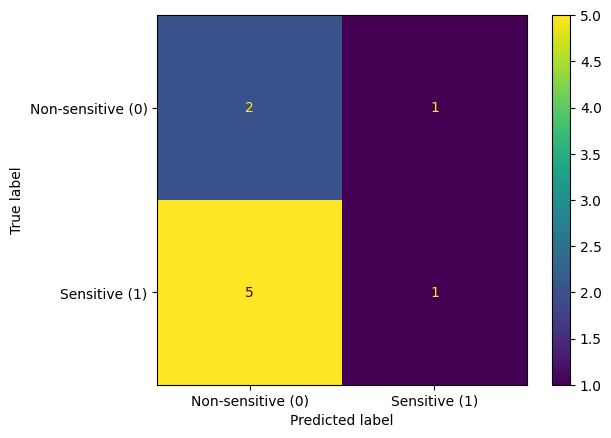

In [28]:
predictions, further_processing_required, model_responses, scikit_true, scikit_pred = llm_experiment(preproc_df, base_prompt_template)
evaluation_summary("Llama-2", scikit_true, scikit_pred)

In [29]:
model_responses

{'177860_0': '\n  Attribute: \n  \nSensitive - The Text contains sensitive personal information (email metadata), so it should be class',
 '177860_1': '\n  Attribute: \n   Non-sensitive',
 '54263_0': '\n  Attribute: \n   Non-sensitive',
 '54263_1': '\n  Attribute: \n  \n  Non-sensitive',
 '54263_2': '\n  Attribute: \n  \nNon-sensitive. The Text does not contain any sensitive personal information, such as full names',
 '54263_3': '\n  Attribute: \n  \nNon-sensitive\n\nReason: The Text does not contain any sensitive personal information,',
 '54629_0': '\n  Attribute: \n   Non-sensitive',
 '54629_1': '\n  Attribute: \n  \nNon-sensitive\n\nReason: The Text does not contain any sensitive personal information,',
 '175555': '\n  Attribute: \n  \n  Sensitive: No\n  Reason: The Text does not contain any sensitive personal'}

Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      0.842     0.941     0.889        17
    Sensitive (1)      0.000     0.000     0.000         3

         accuracy                          0.800        20
        macro avg      0.421     0.471     0.444        20
     weighted avg      0.716     0.800     0.756        20



Confusion matrix:


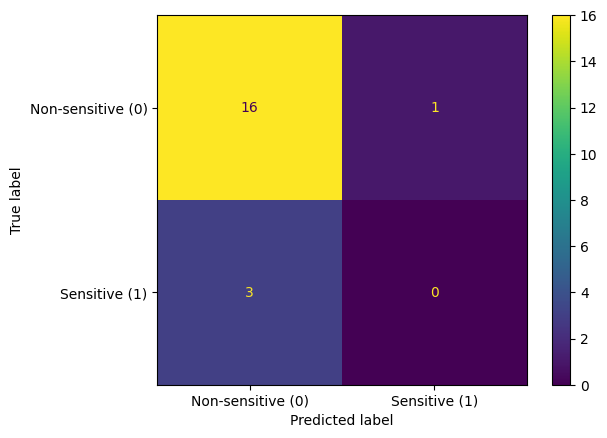

In [71]:
predictions1, further_processing_required1, model_responses1, scikit_true1, scikit_pred1 = llm_experiment(gg, base_w_sys)
evaluation_summary("Llama-2", scikit_true1, scikit_pred1)

Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      0.667     0.353     0.462        17
    Sensitive (1)      0.000     0.000     0.000         3

         accuracy                          0.300        20
        macro avg      0.333     0.176     0.231        20
     weighted avg      0.567     0.300     0.392        20



Confusion matrix:


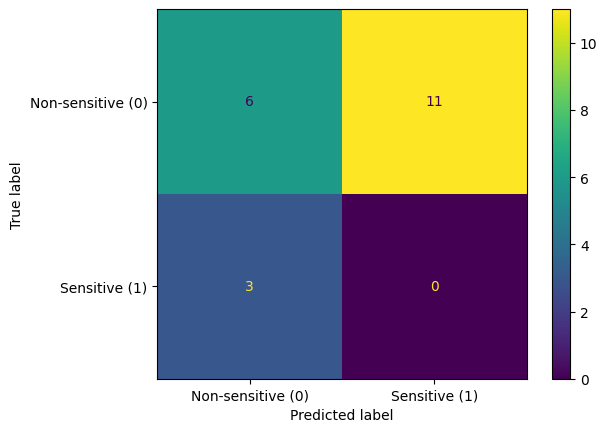

In [74]:
predictions2, further_processing_required2, model_responses2, scikit_true2, scikit_pred2 = llm_experiment(gg, base_w_sys2)
evaluation_summary("Llama-2", scikit_true2, scikit_pred2)

Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      0.000     0.000     0.000         3
    Sensitive (1)      0.667     1.000     0.800         6

         accuracy                          0.667         9
        macro avg      0.333     0.500     0.400         9
     weighted avg      0.444     0.667     0.533         9



Confusion matrix:


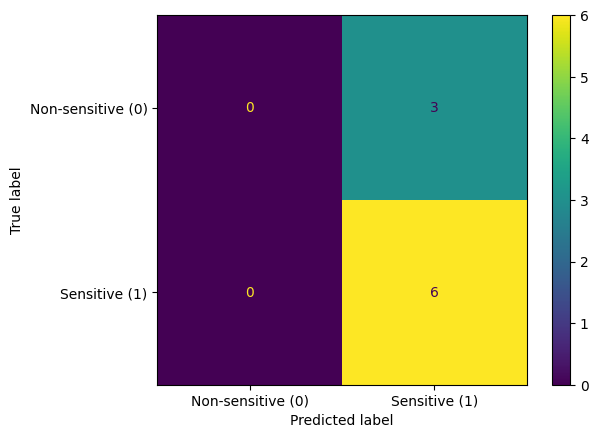

In [35]:
predictions3, further_processing_required3, model_responses3, scikit_true3, scikit_pred3 = llm_experiment(preproc_df, base_w_sys4)
evaluation_summary("Llama-2", scikit_true3, scikit_pred3)

In [36]:
model_responses3

{'177860_0': '\n  <ANSWER>\n   Sensitive\n  </ANSWER>\n  \n  Explanation: The Text',
 '177860_1': '\n  <ANSWER>\n   Sensitive\n   </ANSWER>\n\nExplanation:\nThe Text contains',
 '54263_0': '\n  <ANSWER>\n   Sensitive\n  </ANSWER>\n```\n\nThe Text is not sensitive if',
 '54263_1': '\n  <ANSWER>\n   Sensitive\n  </ANSWER>\n\nExplanation:\nThe Text contains',
 '54263_2': '\n  <ANSWER>\n   Sensitive\n  </ANSWER>\n\nExplanation:\nThe Text contains',
 '54263_3': '\n  <ANSWER>\n   Sensitive\n  </ANSWER>\n\nExplanation:\n\nThe Text',
 '54629_0': '\n  <ANSWER>\n   Sensitive\n  </ANSWER>\n  \n  Explanation: The Text',
 '54629_1': '\n  <ANSWER>\n   Sensitive\n  </ANSWER>',
 '175555': '\n  <ANSWER>\n   Sensitive\n  </ANSWER>'}

In [ ]:
def get_metric_dict(method, labels, preds):
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    metric_dict = {'accuracy': acc, 'f1_score': f1, 'balanced accuracy': bac}
    print(metric_dict)

get_metric_dict('Llama-2', scikit_true, scikit_pred)
get_metric_dict('Llama-2', scikit_true1, scikit_pred1)
get_metric_dict('Llama-2', scikit_true2, scikit_pred2)
get_metric_dict('Llama-2', scikit_true3, scikit_pred3)

In [55]:
inputs = tokenizer("What does sensitive personal information mean?", return_tensors='pt')
generation_config = GenerationConfig(
    #do_sample=False,
    max_new_tokens=200,
)
output = model.generate(inputs=inputs.input_ids.cuda(), attention_mask=inputs.attention_mask.cuda(), generation_config=generation_config)
ans = tokenizer.decode(output[0], skip_special_tokens=True)

In [76]:
print(ans)

What does sensitive personal information mean?
Sensitive personal information is a term used in data protection laws to describe information that is considered to be particularly sensitive or valuable, and therefore requires additional protection. This can include information about an individual's:

* Financial information, such as bank account details or credit card numbers
* Health information, such as medical records or health insurance details
* Racial or ethnic origin
* Political opinions
* Religious beliefs or affiliations
* Sexual orientation
* Genetic information
* Biometric data, such as fingerprints or facial recognition data

Examples of sensitive personal information may include:

* Financial information, such as bank account details or credit card numbers, which could be used for identity theft or fraud
* Health information, such as medical records or health insurance details, which could be used to discriminate against an individual or to compromise their privacy
* Racial